# MAS Final Homework Assignment
Daniel Engbert, Dec 2022

In [37]:
# helper function for use in code code below
import random
import numpy as np

def set_seed(seed=42):
  rng = random.Random()
  if seed is None:
    seed = random.randint(0, 9999)
  rng.seed(seed)
  np.random.seed(seed)

## Monte Carlo Estimation of Shapely Value

How to fairly split a taxi fare across $\{1, ... N\}$ players can be calculated using [Shapely values](https://en.wikipedia.org/wiki/Shapley_value), which treats this scenario as a cooperative game.
For this problem we assume that all players live on the way of the Nth player, and that player $A$ lives at distance of 1, player $B$ at a distance of 2, etc.

### Computing Shapely values for $n=4$:
The code below computes all permutations (a.k.a. "coalitions") of the $N=4$ players $\{A, B, C, D\}$, then for each permutation, `perm`, it assigns each player a share off the total payoff (the fare of total cost 4), by assuming player `perm[0]` showed up first at the taxi, followed by players `perm[1]`, `perm[2]`, `perm[3]`.

For example, for the permutation `perm = ['A', 'C', 'B', 'D']`, the respective payoffs (fare splits) will be `{'A': 1, 'B': 0, 'C': 2, 'D': 1}` (here player $B$ pays 0 because by the time player he arrives at the taxi, it was already going to go by the his house anyways due to player $C$.)

The final computed Shapely values are simply the average payoffs of each player across all possible permutations.


In [50]:
import random

def get_player_vals(N: int):
    """
    Returns mapping of N player names (strings) to their distance along the taxi route.
    e.g. for N=4: {'A': 1, 'B': 2, 'C': 3', 'D': 4}
    """
    if N <= 26:
        return {chr(ord('A') + n): n+1 for n in range(0, N)}
    return {n+1: n+1 for n in range(0, N)}

def get_perms(arr):
    """returns a list of the possible permutations of the entries in the provided array."""
    all_perms = []
    for p in arr:
        other_elems = sorted(list(set(arr) - set([p])))
        sub_perms = get_perms(other_elems)
        if len(sub_perms) == 0:
            all_perms.append([p])
        else:
            all_perms = all_perms + [[p] + perm for perm in sub_perms]
    return all_perms

def get_shapley(N: int):
    #player_vals = {'A': 6, 'B': 12, 'C': 42} # should result in shapely values {2, 5, 35}
    player_vals = get_player_vals(N)

    print(f"player_vals = {player_vals}")
    players = list(player_vals.keys())

    # list of permutations of coalitions of size len(players)
    perms = get_perms(players)
    print(f"there are {len(perms)} total permutations of {len(players)} players:")
    display(perms[:5]) # print first few rows
    print('(only the first 5 rows of permutations are shown above)')

    running_payoffs = {p: 0 for p in players}
    total_payoff = max(player_vals.values())
    for perm in perms:
        cur = {p: 0 for p in players}
        for p in perm: # compute share of payoff for each player in this permutation
            cur[p] = max(0, player_vals[p] - sum(cur.values()))
        running_payoffs = {k: v+cur[k] for (k,v) in running_payoffs.items()}

    shapely_values = {k: v/len(perms) for (k,v) in running_payoffs.items()}
    print(f"\nshapley_values: (for N = {N})")
    print(shapely_values)

    #print('percent of payoff:')
    #print({k: v/total_payoff for (k,v) in shapely_values.items()})

get_shapley(4)


player_vals = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
there are 24 total permutations of 4 players:


[['A', 'B', 'C', 'D'],
 ['A', 'B', 'D', 'C'],
 ['A', 'C', 'B', 'D'],
 ['A', 'C', 'D', 'B'],
 ['A', 'D', 'B', 'C']]

(only the first 5 rows of permutations are shown above)

shapley_values: (for N = 4)
{'A': 0.25, 'B': 0.5833333333333334, 'C': 1.0833333333333333, 'D': 2.0833333333333335}


As can be seen from the output, the shapely values for $n=4$ players is `{'A': 0.25, 'B': 0.583, 'C': 1.083, 'D': 2.083}`

### Estimating Shapley values for $n=100$
Here we use [Monte Carlo sampling](https://en.wikipedia.org/wiki/Monte_Carlo_method) to approximiate the Shapely values for the taxi fare problem when $n=100$.


estimated shapley values: (for N = 50 players, and 100000 of permutations):
{1: 0.02054, 2: 0.04157, 3: 0.05971, 4: 0.08312, 5: 0.10704, 6: 0.12341, 7: 0.14642, 8: 0.17153, 9: 0.20036, 10: 0.21856, 11: 0.25418, 12: 0.2726, 13: 0.30493, 14: 0.33462, 15: 0.35186, 16: 0.37605, 17: 0.40556, 18: 0.43444, 19: 0.47223, 20: 0.52456, 21: 0.53544, 22: 0.58973, 23: 0.60535, 24: 0.63494, 25: 0.7026, 26: 0.72011, 27: 0.75406, 28: 0.79576, 29: 0.82959, 30: 0.8871, 31: 0.97181, 32: 1.02784, 33: 1.03342, 34: 1.11018, 35: 1.16159, 36: 1.25415, 37: 1.3153, 38: 1.38205, 39: 1.4687, 40: 1.55524, 41: 1.66011, 42: 1.78025, 43: 1.88723, 44: 2.03769, 45: 2.22738, 46: 2.45, 47: 2.59895, 48: 2.98686, 49: 3.55325, 50: 4.58003}


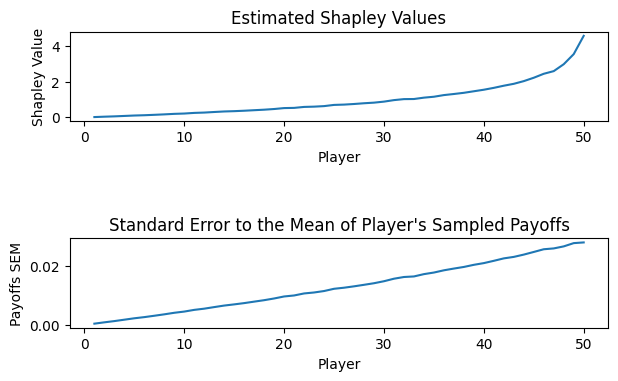

In [60]:
import matplotlib.pyplot as plt
import scipy

def get_random_perm(vals):
    """returns a random permutation of the entries in the provided set."""
    assert len(vals) > 0

    item = random.choice(list(vals))
    if len(vals) > 1:
        return [item] + get_random_perm(vals - set([item]))
    return [item]

def estimate_shapley(N: int, samples: int):
    player_vals = get_player_vals(N)

    players = list(player_vals.keys())
    players_set = set(players)

    # store list of sampled payoffs for each player
    running_payoffs = {p: [] for p in players}
    total_payoff = max(player_vals.values())
    for _ in range(samples):
        perm = get_random_perm(players_set)
        cur = {p: 0 for p in players}
        for p in perm: # compute share of payoff for each player in this permutation
            cur[p] = max(0, player_vals[p] - sum(cur.values()))
            running_payoffs[p].append(cur[p])
        #running_payoffs = {k: v+cur[k] for (k,v) in running_payoffs.items()}

    shapely_values = {k: sum(pays)/samples for (k,pays) in running_payoffs.items()}
    print(f"\nestimated shapley values: (for N = {N} players, and {samples} of permutations):")
    print(shapely_values)

    fig, axs = plt.subplots(2)
    fig.tight_layout(pad=6.0)
    fig.set_size_inches(8, 5)
    axs[0].set_title(f"Estimated Shapley Values")
    axs[0].set_xlabel(f'Player')
    axs[0].set_ylabel(f"Shapley Value")
    axs[0].plot(players, [shapely_values[p] for p in players])

    axs[1].set_title(f"Standard Error to the Mean of Player's Sampled Payoffs")
    axs[1].set_xlabel(f'Player')
    axs[1].set_ylabel(f"Payoffs SEM")
    sems = [scipy.stats.sem(pays) for player, pays in running_payoffs.items()]
    axs[1].plot(player_vals.keys(), sems)



estimate_shapley(50, 100000)

---
## Monte Carlo Tree Search (MCTS)

target node = 733, num leaf nodes = 512, max distance: 9, min distance: 0


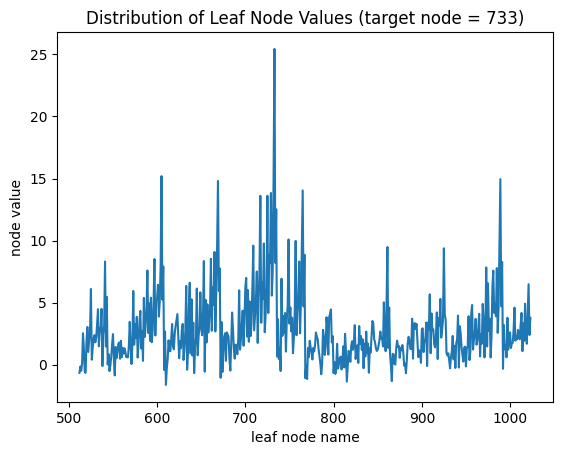

In [40]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import importlib
import tree_search as ts
importlib.reload(ts)

#### experiment params
set_seed(None)
depth = 10
B = 25      # for computing values of leaf nodes
####

tree = ts.create_tree(depth)
#nx.draw(tree, with_labels=True, node_size=300)

first_leaf_node = tree.number_of_nodes() - 2**(depth-1) + 1
leaf_node_names = list(range(first_leaf_node, tree.number_of_nodes()+1))
#print(f"leaf nodes: {leaf_node_names}")

target_name = random.choice(leaf_node_names)
dists = [ts.edit_distance(tree.nodes[n]['address'], tree.nodes[target_name]['address']) for n in leaf_node_names]
dmax = max(dists)
#print(f"dists: {dists}")
print(f"target node = {target_name}, num leaf nodes = {len(leaf_node_names)}, max distance: {dmax}, min distance: {min(dists)}")
# compute values for each leaf node based on distance from target node
for idx, n in enumerate(leaf_node_names):
    tree.nodes[n]['value'] = B * math.pow(math.e, (-5 * dists[idx] / dmax)) + np.random.normal()

leaf_vals = [tree.nodes[n]['value'] for n in leaf_node_names]
#print(f"vals: {leaf_vals}")

plt.xlabel('leaf node name')
plt.ylabel('node value')
plt.title(f'Distribution of Leaf Node Values (target node = {target_name})')
plt.plot(leaf_node_names, leaf_vals)


---
## RL: SARSA and Q-Learning

In [41]:
import numpy as np

EMPTY = 0
WALL = 1
SNAKES = 2
TREASURE = 3

def create_world():
  world = np.zeros((9,9), dtype=int)
  world[1, 2:7] = WALL
  world[1:5, 6] = WALL
  world[7, 1:5] = WALL
  world[6:5] = SNAKES
  world[-1, -1] = TREASURE
  return world

world = create_world()
display(world)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3]])